In [2]:
from IPython.display import clear_output

import os
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline

In [4]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1XHWS4PqmnMaR2pID0bPsVtVeohZpKgTF'
destination = './extracted_data_label.npz'
download_file_from_google_drive(file_id, destination)

ConnectionError: HTTPSConnectionPool(host='docs.google.com', port=443): Max retries exceeded with url: /uc?export=download&id=1XHWS4PqmnMaR2pID0bPsVtVeohZpKgTF (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x0000029AFBDDFE80>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))

In [3]:
#####################
# Set parameters
#####################

# Data params
noise_var = 0
num_datapoints = 100
test_size = 0.2
num_train = int((1 - test_size) * num_datapoints)

# Network params
input_size = 2
hidden_layer = 128
output_dim = input_size
num_layers = 2
num_epochs = 500
dtype = torch.float
input_seq = 60
pred_length = 20
batch_size = 32
train_samples = 10
test_samples = 100

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#####################
# Load data
#####################

def load_data(train=True, seq_pred=True):
    extract_file = './sequences/extracted_data_label.npz'
    if not os.path.isfile(extract_file):
        data = []
        label = []
        max_seq_len = 0
        for file in tqdm(os.listdir('./sequences/')):
            if file.endswith('inputdata.txt'):
                curr_seq = np.loadtxt(os.path.join('./sequences/', file), delimiter=' ')
                data.append(np.cumsum(curr_seq[:, 0:2], axis=0))
                if curr_seq.shape[0] > max_seq_len:
                    max_seq_len = curr_seq.shape[0]
                target_file = file.replace('inputdata', 'targetdata')
                tar_seq = np.loadtxt(os.path.join('./sequences/', target_file), delimiter=' ')
                tmp_label = tar_seq[0, 0:10]
                tmp_label = np.where(tmp_label==1)[0]
                label.append(tmp_label)
        for i in range(len(data)):
            if data[i].shape[0] < max_seq_len:
                data[i] = np.concatenate(
                    [data[i], np.array([data[i][-1, :].tolist(), ] * (max_seq_len - data[i].shape[0]))], axis=0)
        data = np.array(data)
        label = np.array(label)
        np.savez(extract_file, data, label)
    else:
        data_label = np.load(extract_file)
        data = data_label[data_label.files[0]]
        # label = data_label[data_label.files[1]]
    if train:
        x = data[0:60000, 0:input_seq, :]
        y = data[0:60000, input_seq:input_seq + pred_length, :]  #
        x = x[0:int(x.shape[0] / batch_size) * batch_size, :]
        y = y[0:int(x.shape[0] / batch_size) * batch_size, :]

        return (x, y)
    else:
        x = data[60000:, 0:input_seq, :]
        y = data[60000:, input_seq:input_seq + pred_length, :]   #
        x = x[0:int(x.shape[0] / batch_size) * batch_size, :]
        y = y[0:int(x.shape[0] / batch_size) * batch_size, :]
        return (x, y)

(x_data, y_data) = load_data(True)
(x_data_test, y_data_test) = load_data(False)

output_seq = y_data.shape[1]
print(x_data.shape)
print(y_data.shape)

(60000, 60, 2)
(60000, 20, 2)


torch.Size([32, 60, 2])


c:\users\bdb9fe\appdata\local\continuum\anaconda3\envs\pt36\lib\site-packages\matplotlib\pyplot.py:3358: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


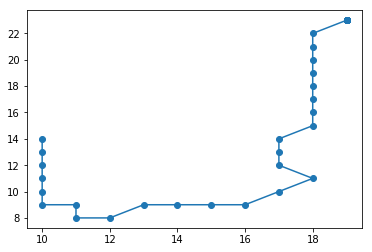

In [7]:
class BatchGenerator(object):
    def __init__(self, data_x, data_y, batch_size=batch_size, output_seq=output_seq, n_action=2):
        self.data_x = data_x  # np.reshape(data_x, (data_x.shape[0], -1))
        self.data_y = data_y  # np.reshape(data_y, (data_y.shape[0], -1))
        self.batch_size = batch_size
        self.output_seq = output_seq
        self.n_action = n_action

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        indices = np.random.randint(0, len(self.data_x), batch_size)
        x_batch = torch.tensor(self.data_x[indices, :, :]).to(torch.float)
        y_batch = torch.tensor(self.data_y[indices, :, :]).to(torch.float)
        return x_batch, y_batch


def draw(sequence):
    to_plot = np.array(sequence).squeeze(1)
    df = pd.DataFrame({'x': to_plot[:, 0], 'y': to_plot[:, 1]})
    plt.plot('x', 'y', data=df, linestyle='-', marker='o')

train_data_generator = BatchGenerator(x_data, y_data, batch_size=batch_size)
test_data_generator = BatchGenerator(x_data_test, y_data_test, batch_size=batch_size)

x_batch, y_batch = train_data_generator.sample()
print(x_batch.shape)
draw(torch.cat((x_batch[0, :, :], y_batch[0, :, :]), 0).cpu().unsqueeze(1).numpy().astype(np.float))

In [8]:
#####################
# Build model
#####################

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size=32):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.linear = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        output = self.linear(input).view(1, batch_size, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, batch_size=32):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.linear = nn.Linear(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        output = self.linear(input).view(1, batch_size, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output[0])
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=output_seq):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

hidden_size = 256
encoder = EncoderRNN(input_size, hidden_layer, batch_size=batch_size).to(device)
decoder = DecoderRNN(hidden_layer, output_dim, batch_size=batch_size).to(device)

In [9]:
#####################
# Train Function
#####################
loss_fn = torch.nn.MSELoss()
learning_rate = 5e-4
# optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
teacher_forcing_ratio = 0.5


def train(x_tensor, y_tensor):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    for e_i in range(x_tensor.size()[1]):
        input_tensor = x_tensor[:, e_i, :]
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = input_tensor

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for d_i in range(y_tensor.size()[1]):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            l = loss_fn(decoder_output, y_tensor[:, d_i, :])
            loss += l
            decoder_input = y_tensor[:, d_i, :]
    else:
        for d_i in range(y_tensor.size()[1]):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            l = loss_fn(decoder_output, y_tensor[:, d_i, :])
            loss += l
            decoder_input = decoder_output

    # Backward pass
    loss.backward()

    # Update parameters
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

def predict(x_tensor, y_tensor, batch_size):
    with torch.no_grad():
        encoder_hidden = torch.zeros(1, batch_size, encoder.hidden_size, device=device)  #  encoder.initHidden()
        loss = 0
        sequence = []
        for e_i in range(x_tensor.size()[1]):
            input_tensor = x_tensor[:, e_i, :]
            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
            sequence.append(input_tensor.cpu().numpy().astype(np.float))

        decoder_input = input_tensor

        decoder_hidden = encoder_hidden

        for d_i in range(y_tensor.size()[1]):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            l = loss_fn(decoder_output, y_tensor[:, d_i, :])
            loss += l
            decoder_input = decoder_output
            sequence.append(decoder_output.cpu().numpy().astype(np.float))

    return loss.item(), sequence

In [10]:
import time
import math

n_iters = 20000
plot_every = 10
test_size = batch_size

# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_test_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    x_batch, y_batch = train_data_generator.sample()
    # category, line, category_tensor, line_tensor = randomTrainingExample()
    loss = train(x_batch, y_batch)
    current_loss += loss

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        print("current_loss: ", current_loss/plot_every)
        all_losses.append(current_loss/plot_every)
        current_loss = 0
        # test_loss
        x_test_batch, y_test_batch = test_data_generator.sample(batch_size=test_size)
        test_loss, _ = predict(x_test_batch, y_test_batch, batch_size=test_size)
        print("current_test_loss: ", test_loss)
        all_test_losses.append(test_loss)

x_test_batch, y_test_batch = test_data_generator.sample(batch_size=5)
for i in range(y_test_batch.size()[0]):
    test_loss, sequence = predict(x_test_batch[i, :, :].unsqueeze(0), y_test_batch[i, :, :].unsqueeze(0), batch_size=1)
    draw(sequence)

plt.figure()
plt.plot(all_losses)
plt.plot(all_test_losses)

current_loss:  1384.8288513183593
current_test_loss:  883.3004150390625
current_loss:  743.1156066894531
current_test_loss:  619.4346313476562
current_loss:  531.9915893554687
current_test_loss:  337.6059265136719
current_loss:  517.8850067138671
current_test_loss:  502.6859436035156
current_loss:  409.39453125
current_test_loss:  390.7309875488281
current_loss:  403.6657440185547
current_test_loss:  1051.936279296875
current_loss:  445.6460296630859
current_test_loss:  404.45233154296875
current_loss:  394.38495178222655
current_test_loss:  489.63543701171875
current_loss:  341.2698440551758
current_test_loss:  750.2383422851562


KeyboardInterrupt: 